In [10]:
import numpy as np
import cv2
import os
import string
import matplotlib.pyplot as plt
import tqdm
from os.path import join
from collections import Counter
import re 
import io
import copy
from tensorflow.keras import layers
import editdistance
import pickle

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, LSTM,GRU, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

Бейзлайн запускался на машине со следующими версиями библиотек.

In [2]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.2.0
Keras version: 2.4.3


* CUDA 10.1
* cv2 4.3.0
* numpy 1.19.2
* re 2.2.1
* tqdm 4.46.0
* matplotlib 3.3.2

**Укажем пути для изображений и текста.**

In [4]:
#В этой папке лежат txt файлы перевода
trans_dir = 'data/train/words'
#В этой папке лежат  jpg файлы изображений
image_dir = 'data/train/images'

print(len(os.listdir(trans_dir)))

6196


Посмотрим на отдельное изображение.

In [5]:
example = os.listdir(image_dir)[0]

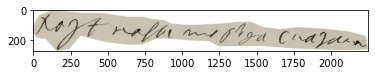

In [6]:
img = plt.imread(image_dir+'/'+example)
plt.imshow(img)
plt.show()

И его перевод.

In [7]:
with io.open(trans_dir+'/'+example[:-3]+'txt', 'r',  encoding='utf8') as file:
    data = file.read()

print(data)

ходѣ] но вы тогъда сказали


В текстах встречаются слова, содержащие английские символы.

Но так как английских символов в целом не очень много, то из train-выборки можно удалить строки с ними (и обучаться только на оставшихся строках). Так мы и сделаем в текущем бейзлайне. Это сократит алфавит (и, как следствие, избавит нас от лишней шумности). 

При этом надо понимать, что в тестовой выборке английские символы, скорее всего, будут присутствовать. Поэтому будут и вынужденные ошибки, связанные с нашей вольной фильтрацией обучающей выборки.

Впрочем, метод распознавания всегда выбираете вы сами. 

Кроме того, советуем внимательно изучить train-выборку глазами.

In [8]:
english = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n' ,'o', 'p', 'r', 's', 't', 'u', 'w']

In [11]:
with open("data/train_uttids_set.pkl", "rb") as f:
    train_uttids = pickle.load(f)
with open("data/val_uttids_set.pkl", "rb") as f:
    val_uttids = pickle.load(f)

In [12]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

Следующая функция подготавливает лэйблы, то есть переведенный текст. Как уже было сказано, игнорируются примеры, содержащие английские буквы.

In [15]:
def process_texts(image_dir,trans_dir):
    lens = []
    include_english = 0
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'txt' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data)==0:
                    continue
                if len(set(data).intersection(english))>0:
                    print(f"skipping {name}: {data}")
                    continue

                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data
    print('Максимальная длина строки:', max(Counter(lens).keys()))
    print('Количество строк с английскими буквами ',include_english)

    return names,lines,Counter(letters)

В итоге мы получаем список изображений, соответствующий ему обработанный список строк и словарь символов.

In [16]:
names,lines,cnt = process_texts(image_dir,trans_dir)

skipping 209_31_12: d другой столбъ с короною явъляюшей
skipping 19_5_0: min her +
skipping 215_38_10: а в точку f iз которой протчия линеi дѣлай
skipping 217_40_19: бери дистанциi на линii e f гдѣ доткнулис линѣ
skipping 163_7_0: sire
skipping 163_4_4: iз санктъпитербурха въ 27 д генваря piter
skipping 217_40_11: казывает в обѣiх углах d] аш] потом
skipping 133_36_0: mrsi
skipping 425_37_0: p s також донеси i то к в
skipping 217_40_14: e f потом iз точки  g начерти полкруга
skipping 188_4_14: мушкѣтная стрелба h какъ все то
skipping 182_4_6: пушки стала а реданы при b bd дѣат
skipping 14_29_10: р s карабль наш сваятого петра сего
skipping 109_7_1: cну i осмотря все быт с полным до
skipping 217_40_21: черчивай паралелныя линѣi гдѣ линѣя a g
skipping 356_4_4: iз лагара въ 27 д iюня piter
skipping 188_4_21: aa
skipping 163_6_4: p s
skipping 17_7_10: р s поздравляем сим днем
skipping 22_11_13: piter
skipping 164_13_0: sire
skipping 337_41_2: гиc областей что
skipping 163_6_0: siire
skippi

In [17]:
letters = set(cnt.keys())

letters = sorted(list(letters))
print('Символы train:', ' '.join(letters))
print("количество:", len(letters))

Символы train:   ) + / 0 1 2 3 4 5 6 7 8 9 [ ] i k l | × ǂ а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я і ѣ – … ⊕ ⊗
количество: 60


Следующая функция подгружает изображения, меняет их до необходимого размера и нормирует.

In [18]:
def process_image(img):
    w, h,_ = img.shape
    
    new_w = 128
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    img = img.astype('float32')
    
    if w < 128:
        add_zeros = np.full((128-w, h,3), 255)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < 1024:
        add_zeros = np.full((w, 1024-h,3), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > 1024 or w > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

**Подготовим обучающие и валидационные данные.**

In [19]:
def generate_data(lines,names,image_dir):
    data_images = []
    data_labels = []
    data_input_length = []
    data_label_length = []
    data_original_text = []
    data_original_image = []
    
    max_label_len = 0
    for line, name in tqdm.tqdm_notebook(zip(lines,names)):
        img = cv2.imread(image_dir+'/'+name)
        original_image = copy.deepcopy(img)
        img = process_image(img)
        try:
            label = text_to_labels(line)
        except:
            print('bad_label')
            continue
        data_images.append(img)
        data_labels.append(label)
        data_input_length.append(255)
        data_label_length.append(len(line))
        data_original_text.append(line)
        data_original_image.append(original_image)
        
        if len(line) > max_label_len:
            max_label_len = len(line)
        
    return data_images, data_labels, data_input_length, data_label_length, \
            data_original_text, data_original_image, max_label_len

Создадим обучающую и валидационную выборки.

In [22]:
lines_train = []
names_train = []

lines_val = []
names_val = []


for num,(line, name) in enumerate(zip(lines,names)):
    uttid = name.split(".")[0]
    if uttid in val_uttids:
        lines_val.append(line)
        names_val.append(name)
    elif uttid in train_uttids:
        lines_train.append(line)
        names_train.append(name)
    else:
        raise Exception(f"unknown {uttid}")

In [23]:
train_images, train_labels, train_input_length, train_label_length, train_original_text, train_original_image, \
        train_max_label_len = generate_data(lines_train, names_train, image_dir)

/home/artbataev/anaconda3/envs/digitalp/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [24]:
val_images, val_labels, val_input_length, val_label_length, val_original_text, val_original_image, \
        val_max_label_len = generate_data(lines_val, names_val, image_dir)

/home/artbataev/anaconda3/envs/digitalp/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [25]:
max_label_len = max(train_max_label_len,val_max_label_len)
print(max_label_len)

71


Выведем пару обработанных изображений с переводом.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


въ 28 д сего мѣсяца без всякого сопъроти


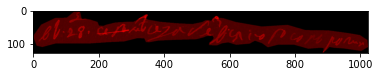

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ване


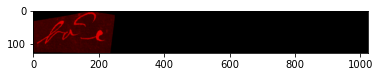

In [26]:
rnd = np.random.choice(range(len(train_images)),2)

for i in rnd:
    print(train_original_text[i])
    plt.imshow(train_images[i])
    plt.show()

**Дополним строки до максимальной длины**

In [27]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

val_padded_label = pad_sequences(val_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

In [28]:
train_padded_label.shape, val_padded_label.shape

((5693, 71), (412, 71))

In [29]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

val_images = np.asarray(val_images)
val_input_length = np.asarray(val_input_length)
val_label_length = np.asarray(val_label_length)

In [30]:
train_images.shape

(5693, 128, 1024, 3)

## **Строим модель**

Модель состоит из нескольких слоев CNN, GRU и использует ctc_loss. [Вот](https://www.youtube.com/watch?v=SAfJ6nP2rrI) хорошее видео о нем на русском.

In [31]:
inputs = Input(shape=(128,1024,3))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(4, 1),padding='same')(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(4, 1),padding='same')(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(letters)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs=inputs, outputs=outputs)
    
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [33]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1024, 3)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 1024, 64)     1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 512, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 512, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 256, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 256, 256)      295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 256, 256)      590080

In [36]:
np.all(train_input_length == 255)

True

In [37]:
batch_size = 20
epochs = 300

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

os.makedirs('checkpoint', exist_ok=True)

filepath="checkpoint/model.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.00001)

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,es,reduce_lr]

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([val_images, val_padded_label, val_input_length, val_label_length], [np.zeros(len(val_images))]),
                    verbose=2,
                    callbacks=callbacks_list)


Epoch 1/300

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to checkpoint/model.hdf5
285/285 - 82s - loss: 97.1710 - accuracy: 0.0000e+00 - val_loss: 91.0031 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/300

Epoch 00002: val_accuracy did not improve from 0.00000
285/285 - 80s - loss: 89.3219 - accuracy: 0.0000e+00 - val_loss: 87.2287 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/300

Epoch 00003: val_accuracy did not improve from 0.00000
285/285 - 80s - loss: 78.8230 - accuracy: 0.0000e+00 - val_loss: 92.5419 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/300

Epoch 00004: val_accuracy did not improve from 0.00000
285/285 - 80s - loss: 36.5967 - accuracy: 1.7565e-04 - val_loss: 62.1775 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/300

Epoch 00005: val_accuracy improved from 0.00000 to 0.00728, saving model to checkpoint/model.hdf5
285/285 - 82s - loss: 18.9235 - accuracy: 0.0026 - val_loss: 15.8422 - val_accuracy: 0.0073 - lr: 0.0010
Epoch 6/300

Epoch 0

Посмотрим качество на валидации.

In [ ]:
# loss: 91 -> 87 -> 92 -> 62 -> 15 -> 14 -> 13 -> 12 -> 11 -> 12 -> 10...

In [38]:
import time

In [39]:
start = time.time()
act_model.load_weights(filepath)
prediction = act_model.predict(val_images)

decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)
end = time.time()
print(end-start)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
4.532464265823364


In [40]:
numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(out)):
    pred = ''
    for p in out[i]:
        if int(p) != -1:
            pred+=letters[int(p)]
    true = val_original_text[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[ERR:26] "+ но хорошо мужикоф содержите" -> "+ к"
[ERR:2] "i тако пѣхота далее" -> "iтако пѣхота дале"
[ERR:2] "римут то б хотя шквадру от 7" -> "римут то б хотя шк вадру от7"
[ERR:1] "рыхъ нужъдахъ пишетъ i то вы" -> "рыхъ нужъ дахъ пишетъ i то вы"
[OK] "чтоб мнѣ мое писмо поттвердит" -> "чтоб мнѣ мое писмо поттвердит"
[OK] "жанъ i лутче всякому своей" -> "жанъ i лутче всякому своей"
[OK] "зит" -> "зит"
[OK] "пѣхотою удержат" -> "пѣхотою удержат"
[ERR:3] "нам здес зело докучает аднакож для" -> "нам здес зело до куает аднакождля"
[ERR:2] "ет указ не описываяс всту" -> "ет указ не опиывлаяс всту"
[ERR:4] "ного и возна в заключе" -> "ного авѣзна в закиюче"
[ERR:3] "и протчег" -> "i протзеб"
[OK] "1" -> "1"
[ERR:3] "хотя за далностию i непърестаными отмѣ" -> "хотя задалностию i непърестаны ми отнѣ"
[ERR:1] "обявъляю вам что я сюды приѣхал вчерас" -> "обявъляю вам что я сюды приѣхал вчера"
[ERR:1] "государственных дѣл положит на въ" -> "посударственных дѣл положи

**Загружаем тестовые изображения, делаем предсказания и записываем их в файл.**

Этот ноутбук - публичный бейзлайн. Тестовая выборка будет автоматически подкладываться в образ, куда участник загрузит модель. Поэтому сейчас следующие строчки закомменчены. И пример запуска модели и записи предсказаний в файл будет проведен на валидационных изображениях.

In [37]:
#Для примера работы запуска модели и записи в файл, пусть валидация станет тестовыми изображениями
test_images = val_images
names_test = names_val

In [38]:
#test_image_dir = 'test/images'

In [39]:
# test_images = []
# names_test = []

# for name in  os.listdir(test_image_dir):
#     img = cv2.imread(test_image_dir+'/'+name)
#     img = process_image(img)
#     test_images.append(img)
#     names_test.append(name)
# test_images = np.asarray(test_images)

In [40]:
start = time.time()

prediction =act_model.predict(test_images)
 
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

prediction = []
for i, x in enumerate(out):
    pred = ''
    for p in x:
        if int(p) != -1:
            pred+=letters[int(p)]
            
    prediction.append(pred)
end = time.time()
print(end - start)

2.049828052520752


In [41]:
len(prediction)

407

In [42]:
output_dir = 'predictions'
os.makedirs(output_dir, exist_ok=True)

for num, (name, line) in enumerate(zip(names_test, prediction)):
    with open(os.path.join(output_dir, name.replace('.jpg', '.txt')), 'w') as file:
        file.write(line)

Соберем сабмит для платформы


In [ ]:
! cp checkpoint/model.hdf5 submit_example/checkpoint/
! zip submit.zip -r submit_example
